# Prüfung: AI Engineering: Generatives Lernen mit GAN


# AI Engineering Prüfung: Vom Strich zum Code - KI-basierte Schrifterkennung

---

## Use Case Beschreibung

In dieem Code implementiere ich ein **Generatives Adversarial Network (GAN)**  mit PyTorch, das auf dem MNIST-Datensatz trainiert wird & **CNN (Convolutional Neural Network)** der für die Klassifizerung der Ziffern zuständig ist. 

Als erstes lade ich alle notwendigen Python-Bibliotheken, die ich für das Projekt benötige.

Jede Bibliothek hat eine spezifische Aufgabe:
- **PyTorch**: Das Deep Learning Framework für neuronale Netzwerke
- **Torchvision**: Bildverarbeitung und Datensätze (MNIST)
- **NumPy**: Numerische Berechnungen
- **Matplotlib**: Visualisierungen

### Konzepte:
- **PyTorch ist ein Framework. Es gibt die Struktur vor, wie wir neuronale Netzwerke bauen können**
- **GPU-Beschleunigung**: Ich kann mit PyTorch auch automatisch GPU nutzen lassen für ein schnelleres Training

In [2]:
# IMPORTS
# Standardbibliotheken für grundlegende Operationen
import random          # Für Zufallszahlen (z.B. Seed setzen)
import os              # Für Dateisystem-Operationen
import numpy as np     # Für numerische Arrays und Berechnungen


# PyTorch - Das Herzstück für Deep Learning
import torch                      # Hauptmodul für Tensoren und Autograd
import torch.nn as nn             # Neuronale Netzwerk Module (Layer, Loss, etc.)
import torch.optim as optim       # Optimierer (Adam, SGD, etc.)
from torch.utils.data import DataLoader  # Für effizientes Laden von Daten in Batches

# Torchvision - Bildverarbeitung und Datensätze
import torchvision                            # Hauptmodul
import torchvision.transforms as transforms  # Bildtransformationen
import torchvision.utils as vutils           # Hilfsfunktionen für Bildanzeige

# Matplotlib für Visualisierungen
import matplotlib.pyplot as plt
from matplotlib import cm


if torch.cuda.is_available():
    print(f"Erfolg! GPU erkannt: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("Leider immer noch CPU. Überprüfe die Treiber.")
    device = torch.device("cpu")

print("Alle Imports erfolgreich!")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

Leider immer noch CPU. Überprüfe die Treiber.
Alle Imports erfolgreich!
PyTorch Version: 2.10.0+cpu
Torchvision Version: 0.25.0+cpu


## Device-Konfiguration (GPU/CPU)

### Was macht dieser Code?
Ich prüfe, ob eine GPU (CUDA) verfügbar ist und wählen das beste verfügbare Gerät.

### Warum mache ich das?
- **GPU**: Kann bis zu 100x schneller als CPU für Deep Learning sein
- **Parallelisierung**: GPUs können tausende Operationen gleichzeitig ausführen
CUDA ist NVIDIAs Plattform für GPU-Computing

In [3]:
# Sicherstellen, dass PyTorch die GPU verwenden kann, falls verfügbar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Verwende Gerät: {device}")


# Um die Ergebnisse reproduzierbar zu machen:
# Es muss ein Seed gesetzt werden und deterministische Algorithmen verwendet werden
seed = 99                                   # Ein beliebiger Seed-Wert, z.B. 42, 99, 1234, etc.
print("Random Seed: ", seed)                # Ausgabe des gesetzten Seeds
random.seed(seed)                           # Für die Python-Standardbibliothek
torch.manual_seed(seed)                     # Für CPU
torch.use_deterministic_algorithms(False)   # Manchmal können bestimmte Operationen nicht deterministisch sein, daher auf False setzen



Verwende Gerät: cpu
Random Seed:  99


#### Hyperparameter festlegen 
Hyperparameter sind Einstellungen, die das Training steuern:
- Ich muss die immer VOR dem Training festgelegen
- Ich beeinflusse damit wie gut das Modell lernt
- Falsche Werte können zu schlechtem Training führen

In [3]:
# HYPERPARAMETER-DEFINITION
# Diese Werte steuern das Training und die Netzwerkarchitektur

# Bildparameter
image_size = 28          # Zielgröße der Bilder (28x28 für MNIST)
num_channels = 1         # Anzahl der Farbkanäle (1 für Graustufenbilder)

# GAN Hyperparameter
z_dim = 100              # Generator input, Größe des Rauschvektors für den Generator | Anzahl der Zufallsvariablen, die in den Generator eingespeist werden
ngf = 64                 # Größe der Feature Map im Generator
ndf = 64                 # Größe der Feature Map im Diskriminator
gan_epochs = 25          # Anzahl Trainingsepochen für GAN (reduziert für Demo)
gan_batch_size = 128     # Batch-Größe für GAN-Training

lr_d = 0.0002            # Learning Rate für Diskriminator
lr_g = 0.0002            # Learning Rate für Generator
beta1= 0.5               # Beta1 für Adam Optimizer
beta2 = 0.999            # Beta2 für Adam Optimizer

# CNN Hyperparameter
cnn_epochs = 10           # Anzahl Trainingsepochen für CNN-Klassifikator
cnn_batch_size = 128      # Batch-Größe für CNN-Training
cnn_lr = 0.001            # Learning Rate für CNN-Klassifikator



print(f"Bildgröße: {image_size}x{image_size}")
print(f"Kanäle: {num_channels}")
print(f"\nGAN-Parameter:")
print(f"  - Latent Dim (Z): {z_dim}")
print(f"  - Generator Feature Maps: {ngf}")
print(f"  - Diskriminator Feature Maps: {ndf}")
print(f"  - Epochen: {gan_epochs}")
print(f"  - Batch Size: {gan_batch_size}")



Bildgröße: 28x28
Kanäle: 1

GAN-Parameter:
  - Latent Dim (Z): 100
  - Generator Feature Maps: 64
  - Diskriminator Feature Maps: 64
  - Epochen: 25
  - Batch Size: 128


#### Transformieren des MNIST Datensatzes


In [4]:
# MNIST-DATENSATZ LADEN
# Transformationen: Skalierung, Tensor-Umwandlung, Normalisierung
# Transformation für GAN (Normalisierung auf [-1, 1])

transform_gan = transforms.Compose([
    transforms.Resize(image_size),           # Bilder skalieren falls nötig (hier eigentlich schon 28x28)
    transforms.ToTensor(),                   # In PyTorch Tensor umwandeln und Pixelwerte auf [0, 1] skalieren
    transforms.Normalize((0.5,), (0.5,))     # Normalisiert auf [-1, 1] (Mean=0.5, Stdard Abw=0.5 für 1 Kanal)
])

# MNIST Trainings-Datensatz laden mit den definierten Transformationen
train_dataset_gan = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform_gan,
    download=True
)


# DataLoader erstellen
# DataLoader batcht die Daten und mischt sie für das Training

train_loader_gan = DataLoader(
    train_dataset_gan,
    batch_size=gan_batch_size,
    shuffle=True  # Wichtig: Daten mischen für besseres Training
    )


# Transformation für CNN (MNIST-Standardnormalisierung)
transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST Mittelwert und Standardabweichung
])

train_dataset_cnn = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform_cnn,
    download=True
)

test_dataset_cnn = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform_cnn,
    download=True
)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=cnn_batch_size, shuffle=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=cnn_batch_size, shuffle=False)



print(f"Anzahl Trainingsbilder: {len(train_dataset_gan)}")

print(f"Bildgröße nach Transformation: {image_size}x{image_size} Pixel mit {num_channels} Kanal")

Anzahl Trainingsbilder: 60000
Bildgröße nach Transformation: 28x28 Pixel mit 1 Kanal


# Darstellung TRAININGSBILDER zeigt einige Beispielbilder aus dem MNIST Datensatz

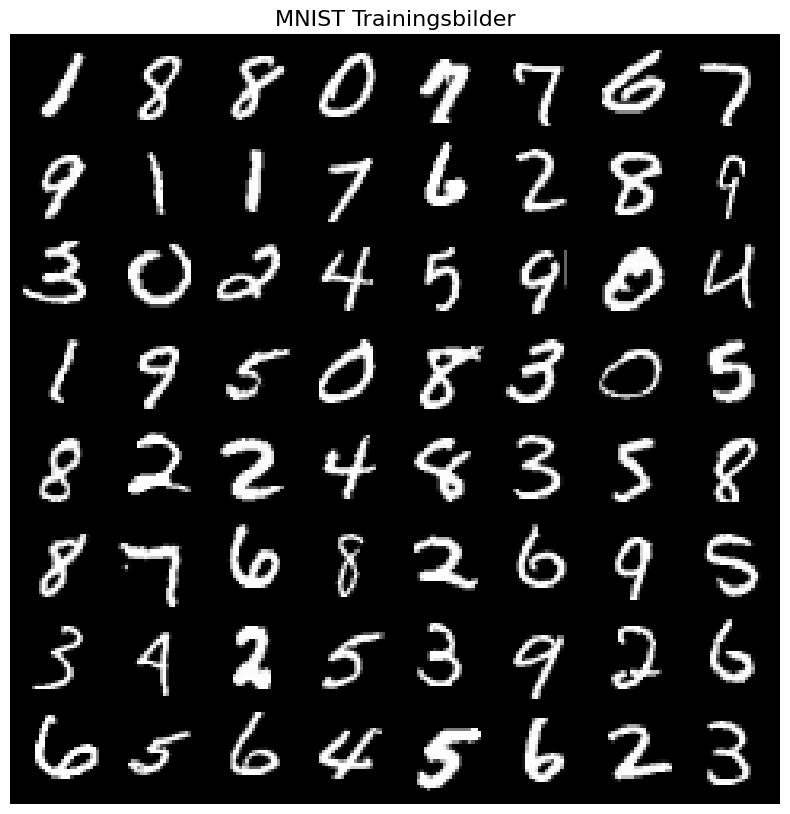

In [5]:
real_batch = next(iter(train_loader_gan)) # Hole einen Batch von Bildern


# Erstelle Grid und zeige an
plt.figure(figsize=(10, 10)) # Größe der Abbildung
plt.axis("off") # Achsen ausblenden für bessere Darstellung
plt.title("MNIST Trainingsbilder", fontsize=16) # Titel hinzufügen
plt.imshow(
    np.transpose( # Verschiebe die Kanäle von (C, H, W) zu (H, W, C) für Matplotlib
        vutils.make_grid( # Erstelle ein Grid aus den Bildern
            real_batch[0][:64],  # Erste 64 Bilder
            padding=2, # Abstand zwischen Bildern im Grid
            normalize=True, # Normalisiert die Bilder für die Anzeige (0-1)
            nrow=8 # Anzahl der Bilder pro Zeile im Grid
        ).cpu(), # Verschiebe die Kanäle von (C, H, W) zu (H, W, C) für Matplotlib
        (1, 2, 0) # Transponieren von (C, H, W) zu (H, W, C)
    )
)
plt.show() # Zeige die Abbildung an

### GAN-Implementierung

# 1. Generator definieren

In [6]:
# Der Generator nimmt einen zufälligen Vektor (Rauschen) und erstellt daraus ein Bild

class Generator(nn.Module):
    """
    Generator-Netzwerk für das GAN.

    Architektur:
    - Mehrere Linear-Schichten mit BatchNorm und LeakyReLU
    - Tanh-Aktivierung am Ende für Ausgabe in [-1, 1]

    Input: Zufälliger Vektor der Größe z_dim
    Output: Bild als 1D-Vektor (wird später reshape zu 28x28)
    """

    def __init__(self, latent_dim, ngf, output_size, alpha_relu=0.2): # Konstruktor mit Hyperparametern
        super().__init__()
        # Schichten können direkt über Sequential definiert werden
        # Sequential-Container für die Schichten
        self.layers = nn.Sequential(
            # Erstes Upsampling: z_dim -> 2*ngf
            nn.Linear(latent_dim, 2 * ngf, bias=False),   # Kein Bias wegen BatchNormisierung was folgt
            nn.BatchNorm1d(2 * ngf),                      # Normalisierung für stabiles Training
            nn.LeakyReLU(alpha_relu),                     # Aktivierungsfunktion LeakyRelu wird oft in GANs verwendet, um das Problem der "toten Neuronen" zu vermeiden, das bei ReLU auftreten kann.
                                                           #LeakyReLU erlaubt einen kleinen negativen Wert für negative Eingaben, was die Gradientenfluss auch für diese Fälle ermöglicht.

            # Zweites Upsampling: 2*ngf -> 4*ngf
            nn.Linear(2 * ngf, 4 * ngf, bias=False),
            nn.BatchNorm1d(4 * ngf),
            nn.LeakyReLU(alpha_relu),

            # Drittes Upsampling: 4*ngf -> 8*ngf
            nn.Linear(4 * ngf, 8 * ngf, bias=False),
            nn.BatchNorm1d(8 * ngf),
            nn.LeakyReLU(alpha_relu),

            # Finales Upsampling: 8*ngf -> output_size (784 für 28x28)
            nn.Linear(8 * ngf, output_size, bias=False),
            nn.Tanh()  # Ausgabe auf [-1, 1] normalisieren

            # Mehrere Upsampling-Schichten werden hinzugefügt, um die Komplexität des Generators zu erhöhen und realistischere Bilder zu erzeugen

        )

    def forward(self, x):
        """Forward Pass durch das Generator-Netzwerk"""
        return self.layers(x)

print("Generator-Klasse definiert.")

Generator-Klasse definiert.


# 2. Diskriminator definieren

In [7]:
# Der Diskriminator bewertet, ob ein Bild echt oder gefälscht ist

class Discriminator(nn.Module):
    """
    Diskriminator-Netzwerk für das GAN.

    Architektur:
    - Mehrere Linear-Schichten mit LeakyReLU
    - Sigmoid am Ende für Wahrscheinlichkeit (0=fake, 1=real)

    Input: Bild als 1D-Vektor (784 für 28x28)
    Output: Wahrscheinlichkeit, dass das Bild echt ist
    """

    def __init__(self, input_size, ndf, alpha_relu=0.2):
        super().__init__()

        self.layers = nn.Sequential(
            # Erste Schicht: input_size -> 16*ndf
            nn.Linear(input_size, 16 * ndf),
            nn.LeakyReLU(alpha_relu),

            # Zweite Schicht: 16*ndf -> 8*ndf
            nn.Linear(16 * ndf, 8 * ndf),
            nn.LeakyReLU(alpha_relu),

            # Dritte Schicht: 8*ndf -> 4*ndf
            nn.Linear(8 * ndf, 4 * ndf),
            nn.LeakyReLU(alpha_relu),

            # Letzte Schicht: 4*ndf -> 1 (Ausgabe)
            nn.Linear(4 * ndf, 1),
            nn.Sigmoid()  # Wahrscheinlichkeit zwischen 0 und 1
        )

    def forward(self, x):
        """Forward Pass durch das Diskriminator-Netzwerk"""
        return self.layers(x)

print("Diskriminator-Klasse definiert.")

Diskriminator-Klasse definiert.


# 3. Instanzen der Netze erstellen

In [8]:
# Erstellen der Generator- und Diskriminator-Instanzen

# Berechne die Output-Größe für den Generator (28 * 28 * 1 = 784)
output_size = image_size * image_size * num_channels

# Generator erstellen
netG = Generator(
    latent_dim=z_dim,
    ngf=ngf,
    output_size=output_size
).to(device)

# Diskriminator erstellen
netD = Discriminator(
    input_size=output_size,
    ndf=ndf
).to(device)

# Zeige die Netzwerkarchitekturen
print("Generator Architektur")
print(netG)

print("\nDiskriminator Architektur")
print(netD)

Generator Architektur
Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=128, out_features=256, bias=False)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=256, out_features=512, bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=512, out_features=784, bias=False)
    (10): Tanh()
  )
)

Diskriminator Architektur
Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Li


#  4. VERLUSTFUNKTION UND OPTIMIERER 

In [9]:
# Binary Cross-Entropy Loss Verlustfunktion für das GAN-Training
# Diese Funktion misst, wie gut D echte/gefälschte Bilder unterscheiden kann
criterion = nn.BCELoss() # Binary Cross-Entropy Loss misst die Differenz zwischen den vorhergesagten Wahrscheinlichkeiten und
                         # den tatsächlichen Labels (1 für echt, 0 für gefälscht).
                         # Es ist die Standardverlustfunktion für binäre Klassifikationsprobleme, wie sie im GAN-Training auftreten.

# Labels für das Training
real_label = 1.0  # Label für echte Bilder
fake_label = 0.0  # Label für gefälschte Bilder

# Adam-Optimierer für beide Netzwerke dient zum Aktualisieren der Gewichte basierend auf den berechneten Gradienten
# Adam kombiniert Momentum und adaptive Learning Rates für schnelleres und stabileres Training
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, beta2))



print("Verlustfunktion: Binary Cross-Entropy")
print("Optimierer: Adam")
print(f"Learning Rate (G): {lr_g}")
print(f"Learning Rate (D): {lr_d}")

Verlustfunktion: Binary Cross-Entropy
Optimierer: Adam
Learning Rate (G): 0.0002
Learning Rate (D): 0.0002


# 5. Training des GANs

 GAN TRAINING LOOP Trainingdes GANs
 

In [10]:
# Hier findet das eigentliche Training statt

# Listen für Trainingsstatistiken
G_losses = []  # Generator-Verluste
D_losses = []  # Diskriminator-Verluste
img_list = []  # Generierte Bilder für Visualisierung

# Feste Rauschvektoren um den Fortschritt zu visualisieren
fixed_noise = torch.randn(64, z_dim, device=device)

print(f"Starte GAN Training für {gan_epochs} Epochen...") # Ausgabe des Startes des Trainings mit der Anzahl der Epochen
print("=" * 70)                                           # Trennlinie für bessere Lesbarkeit der Ausgabe

for epoch in range(gan_epochs): # Äußere Schleife über die Anzahl der Epochen
    for i, data in enumerate(train_loader_gan): # Innere Schleife über die Batches des DataLoaders

        # SCHRITT 1: DATEN VORBEREITEN
        # Echte Bilder aus dem Batch holen
        real_images = data[0].to(device) # Bilder auf das Gerät (GPU/CPU) verschieben bzw. echte Bilder aus dem Batch holen
        batch_size = real_images.size(0) # Aktuelle Batch-Größe (kann am Ende des Datasets kleiner sein) wieviele Bilder sind in diesem Batch

        # Labels erstellen (alle 1 für reale Bilder)
        label = torch.full((batch_size, 1), real_label, dtype=torch.float, device=device)  #

        # Bilder flach machen in 1D (28x28 -> 784)
        real_images = real_images.view(batch_size, -1)

        # SCHRITT 2: DISKRIMINATOR TRAINIEREN
        # Der Diskriminator soll lernen, echte von gefälschten Bildern zu unterscheiden

        netD.zero_grad()  # Gradienten zurücksetzen

        # A) Training mit echten Bildern
        output = netD(real_images) # Diskriminator bewertet die echten Bilder
        errD_real = criterion(output, label)  # Verlust Lost für reale Bilder Sollte nahe 1 sein
        errD_real.backward() #Backward-Pass berechnet die Gradienten für die Gewichte des Diskriminators basierend
                            # auf dem Fehler zwischen den vorhergesagten Wahrscheinlichkeiten und den tatsächlichen Labels (1 für echt).

        D_x = output.mean().item()  # Durchschnittliche D-Ausgabe für reale echte Bilder

        # B) Training mit gefälschten Bildern
        noise = torch.randn(batch_size, z_dim, device=device)
        fake = netG(noise)  # Generator erstellt gefälschte Bilder
        label.fill_(fake_label)  # Labels auf 0 setzen


        output = netD(fake.detach())# Diskriminator Ausgabe detach() verhindert, dass G aktualisiert wird

       # Fehlerberechnung der gefälschten Bilder
        errD_fake = criterion(output, label)  # Sollte nahe 0 sein
        errD_fake.backward() #Backward-Pass berechnet die Gradienten für die Gewichte des Diskriminators basierend
        D_G_z1 = output.mean().item()  #Durchschnittlioche Diskriminator-Ausgabe für gefälschte Bilder (vor Generator-Update)

        # Gesamtverlust und Update
        errD = errD_real + errD_fake
        optimizerD.step() # Aktualisiere die Gewichte des Diskriminators basierend auf den berechneten Gradienten

        #SCHRITT 3: GENERATOR TRAINIEREN
        # Der Generator soll lernen, den Diskriminator zu täuschen

        netG.zero_grad() #Setze die Gradienten des Generators zurück
        label.fill_(real_label)  # Labels sind jetzt real 1 um Generator zu trainieren, Wir wollen, dass Diskiriminator die Fakes als echt klassifiziert

        output = netD(fake)  # Jetzt ohne detach() Diskriminator Ausgabe für die gefälschten Bilder (nach Generator-Update neu generierte Bilder)
        errG = criterion(output, label)  # G will, dass D 1 ausgibt Verlustberechnung des Generators basierend auf der Ausgabe des Diskriminators für die gefälschten Bilder. Der Generator möchte, dass der Diskriminator diese Bilder als echt klassifiziert (Label=1), daher wird der Verlust berechnet, um diesen Fehler zu minimieren.
        errG.backward() # Backward-Pass berechnet die Gradienten für die Gewichte des Generators basierend auf dem Fehler zwischen den vorhergesagten Wahrscheinlichkeiten des Diskriminators und den tatsächlichen Labels (1 für echt), da der Generator möchte, dass der Diskriminator die gefälschten Bilder als echt klassifiziert.
        D_G_z2 = output.mean().item()  # Durchschnittliche Diskriminator-Ausgabe nach Generator-Update

        optimizerG.step() # Generator-Gewichte aktualisieren basierend auf den berechneten Gradienten

        #SCHRITT 4: STATISTIKEN SPEICHERN
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Fortschritt ausgeben (alle 200 Batches)
        if i % 200 == 0:
            print(f"[{epoch+1}/{gan_epochs}][{i:4d}/{len(train_loader_gan)}] "
                  f"Loss_D: {errD.item():.4f}  Loss_G: {errG.item():.4f}  "
                  f"D(x): {D_x:.4f}  D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

    # Am Ende jeder Epoche: Generierte Bilder speichern
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()
        fake_images = fake_images.view(-1, num_channels, image_size, image_size)
        img_list.append(fake_images)

print("GAN Training beendet!")

Starte GAN Training für 25 Epochen...
[1/25][   0/469] Loss_D: 1.4104  Loss_G: 0.6867  D(x): 0.4943  D(G(z)): 0.5062/0.5032
[1/25][ 200/469] Loss_D: 1.0993  Loss_G: 0.5111  D(x): 0.5471  D(G(z)): 0.3710/0.6060
[1/25][ 400/469] Loss_D: 1.2901  Loss_G: 0.3070  D(x): 0.3628  D(G(z)): 0.1715/0.7400
[2/25][   0/469] Loss_D: 1.0364  Loss_G: 0.6661  D(x): 0.5198  D(G(z)): 0.2843/0.5222
[2/25][ 200/469] Loss_D: 0.8681  Loss_G: 1.3374  D(x): 0.5489  D(G(z)): 0.1692/0.2748
[2/25][ 400/469] Loss_D: 1.6530  Loss_G: 0.1115  D(x): 0.2998  D(G(z)): 0.0626/0.8955
[3/25][   0/469] Loss_D: 0.7113  Loss_G: 1.4487  D(x): 0.7084  D(G(z)): 0.2680/0.2545
[3/25][ 200/469] Loss_D: 0.6437  Loss_G: 2.0228  D(x): 0.8036  D(G(z)): 0.3207/0.1411
[3/25][ 400/469] Loss_D: 1.1805  Loss_G: 2.3451  D(x): 0.9364  D(G(z)): 0.6148/0.1211
[4/25][   0/469] Loss_D: 0.6434  Loss_G: 1.4731  D(x): 0.7160  D(G(z)): 0.2197/0.2675
[4/25][ 200/469] Loss_D: 0.8641  Loss_G: 0.3938  D(x): 0.5620  D(G(z)): 0.1460/0.6993
[4/25][ 400/469]

# VISUALISIERUNG DER VERLUSTE

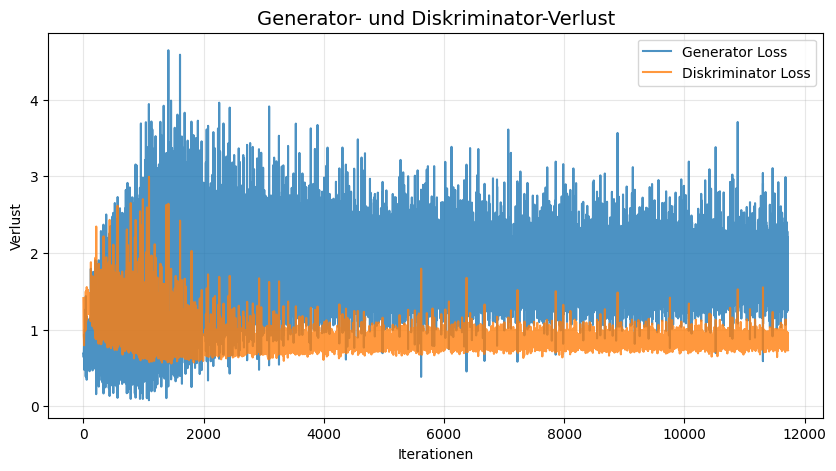

In [11]:
# Zeigt, wie sich G und D während des Trainings entwickelt haben

plt.figure(figsize=(10, 5))

plt.title("Generator- und Diskriminator-Verlust", fontsize=14)
plt.plot(G_losses, label="Generator Loss", alpha=0.8) # alpha=0.8 macht die Linien etwas transparenter, damit sie sich nicht überlagern
plt.plot(D_losses, label="Diskriminator Loss", alpha=0.8)
plt.xlabel("Iterationen")
plt.ylabel("Verlust")
plt.legend()
plt.grid(True, alpha=0.3) # plt.grid() fügt ein Gitter hinzu, um die Lesbarkeit der Grafik zu verbessern. Das Argument alpha=0.3 macht die Gitterlinien leichter, damit sie die Daten nicht überlagern.
plt.show()

# VISUALISIERUNG GENERIERTER BILDER

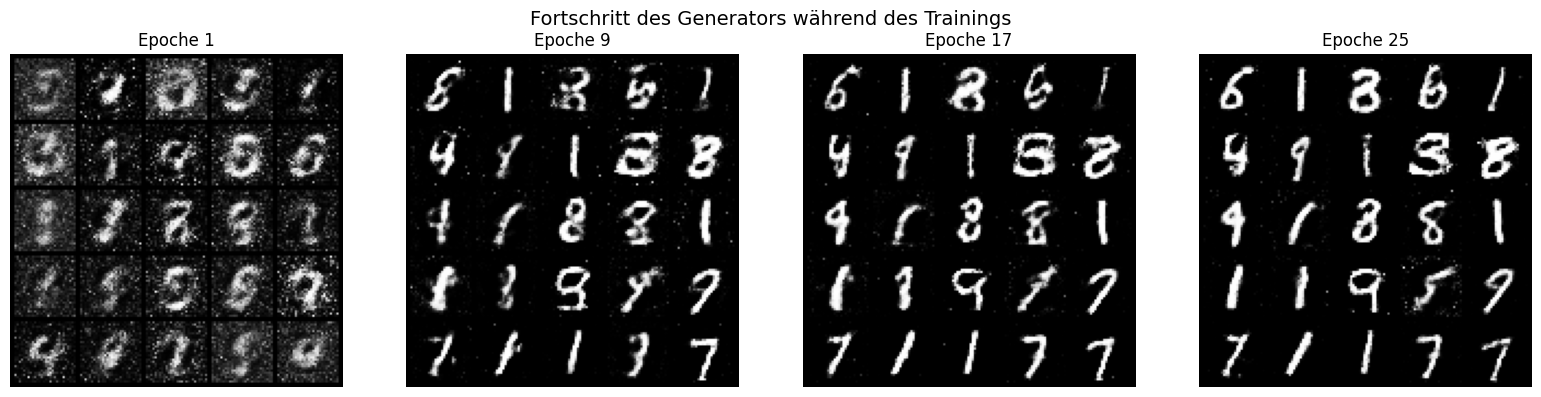

In [12]:
# Zeigt den Fortschritt des Generators über die Epochen

# Zeige Bilder aus verschiedenen Epochen
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

epochs_to_show = [0, gan_epochs//3, 2*gan_epochs//3, gan_epochs-1]

for idx, epoch in enumerate(epochs_to_show):
    axes[idx].axis("off")
    axes[idx].set_title(f"Epoche {epoch+1}", fontsize=12)
    axes[idx].imshow(
        np.transpose(
            vutils.make_grid(
                img_list[epoch][:25],
                padding=2,
                normalize=True,
                nrow=5
            ),
            (1, 2, 0)
        ),
        cmap='gray'
    )

plt.suptitle("Fortschritt des Generators während des Trainings", fontsize=14)
plt.tight_layout()
plt.show()

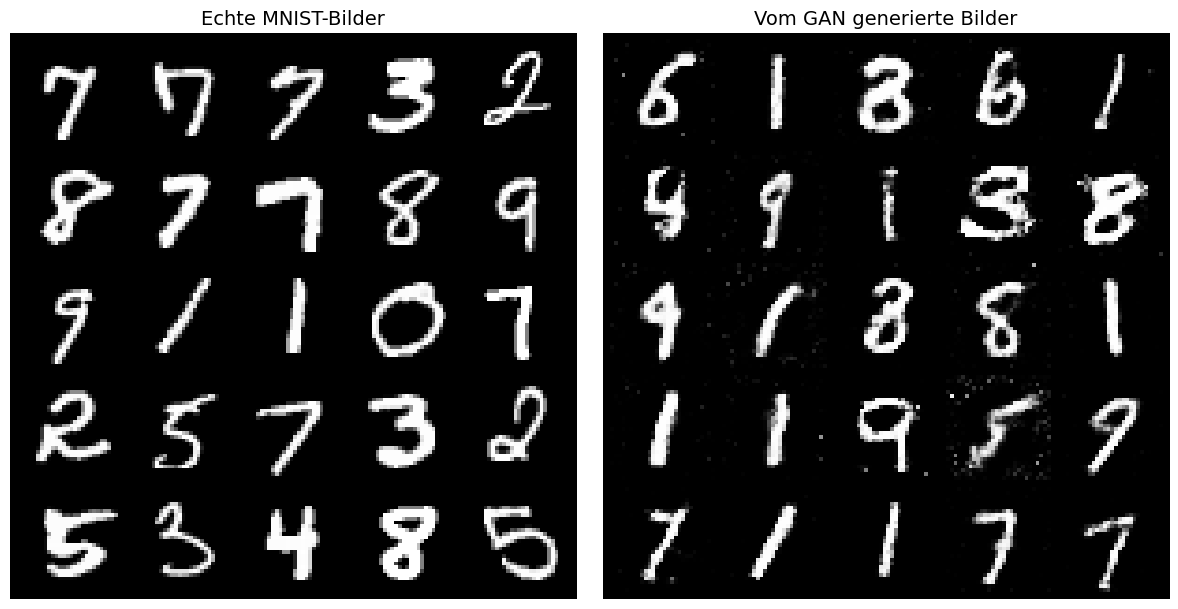

In [13]:
# VERGLEICH: ECHTE VS. GENERIERTE BILDER

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Echte Bilder
axes[0].axis("off")
axes[0].set_title("Echte MNIST-Bilder", fontsize=14)
real_batch = next(iter(train_loader_gan))
axes[0].imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0][:25],
            padding=2,
            normalize=True,
            nrow=5
        ).cpu(),
        (1, 2, 0)
    ),
    cmap='gray'
)

# Generierte Bilder
axes[1].axis("off")
axes[1].set_title("Vom GAN generierte Bilder", fontsize=14)
axes[1].imshow(
    np.transpose(
        vutils.make_grid(
            img_list[-1][:25],
            padding=2,
            normalize=True,
            nrow=5
        ),
        (1, 2, 0)
    ),
    cmap='gray'
)

plt.tight_layout()
plt.show()

# CNN Architektur

In [14]:
# CNN-KLASSIFIKATOR ARCHITEKTUR

class CNN_Classifier(nn.Module):
    """
    Convolutional Neural Network für Zahlenerkennung (0-9).

    Architektur:
    - 2 Convolutional Blocks (Conv + ReLU + MaxPool)
    - Dropout für Regularisierung
    - 2 Fully Connected Layers mit ReLU

    Input: (batch, 1, 28, 28)
    Output: (batch, 10) - Logits für jede Klasse
    """

    def __init__(self):
        super(CNN_Classifier, self).__init__()

        # === Convolutional Block 1 ===
        # Input: 1x28x28 -> Output: 32x14x14
        self.conv1 = nn.Conv2d(
            in_channels=1,       # Graustufenbilder
            out_channels=32,     # 32 Feature Maps
            kernel_size=3,       # 3x3 Filter
            padding=1            # Padding um Größe zu erhalten
        )
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Halbiert die Größe

        # === Convolutional Block 2 ===
        # Input: 32x14x14 -> Output: 64x7x7
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1
        )
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # === Dropout für Regularisierung ===
        self.dropout1 = nn.Dropout(0.25)  # 25% der Neuronen werden deaktiviert
        self.dropout2 = nn.Dropout(0.5)   # 50% Dropout vor dem Output

        # === Fully Connected Layers ===
        # Input: 64 * 7 * 7 = 3136 Features
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 Klassen (0-9)

    def forward(self, x):
        """Forward Pass durch das CNN"""
        # Convolutional Block 1
        x = self.conv1(x)      # -> (batch, 32, 28, 28)
        x = self.relu1(x)
        x = self.pool1(x)      # -> (batch, 32, 14, 14)

        # Convolutional Block 2
        x = self.conv2(x)      # -> (batch, 64, 14, 14)
        x = self.relu2(x)
        x = self.pool2(x)      # -> (batch, 64, 7, 7)

        x = self.dropout1(x)

        # Flatten
        x = x.view(x.size(0), -1)  # -> (batch, 3136)

        # Fully Connected
        x = self.fc1(x)        # -> (batch, 128)
        x = self.relu3(x)
        x = self.dropout2(x)
        x = self.fc2(x)        # -> (batch, 10)

        return x

# Modell erstellen
cnn_model = CNN_Classifier().to(device)

print("CNN Klassifikator Architektur")
print(cnn_model)
print(f"\nAnzahl Parameter: {sum(p.numel() for p in cnn_model.parameters()):,}")

CNN Klassifikator Architektur
CNN_Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Anzahl Parameter: 421,642


In [15]:
# ===== CNN TRAINING =====

# Verlustfunktion und Optimizer
criterion_cnn = nn.CrossEntropyLoss()  # Für Multi-Class Klassifikation
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=cnn_lr)

# Listen für Metriken
train_losses = []
train_accuracies = []
test_accuracies = []

print(f"Starte CNN Training für {cnn_epochs} Epochen...")
print("=" * 70)

for epoch in range(cnn_epochs):
    # === TRAINING PHASE ===
    cnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(train_loader_cnn):
        images = images.to(device)
        labels = labels.to(device)

        # Forward Pass
        optimizer_cnn.zero_grad()
        outputs = cnn_model(images)
        loss = criterion_cnn(outputs, labels)

        # Backward Pass
        loss.backward()
        optimizer_cnn.step()

        # Statistiken
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Trainings-Metriken
    train_accuracy = 100 * correct_train / total_train
    avg_loss = running_loss / len(train_loader_cnn)
    train_accuracies.append(train_accuracy)
    train_losses.append(avg_loss)

    # === EVALUATION PHASE ===
    cnn_model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader_cnn:
            images = images.to(device)
            labels = labels.to(device)

            outputs = cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoche [{epoch+1}/{cnn_epochs}]  "
          f"Loss: {avg_loss:.4f}  "
          f"Train Acc: {train_accuracy:.2f}%  "
          f"Test Acc: {test_accuracy:.2f}%")

print("\n" + "=" * 70)
print(f"CNN Training beendet! Finale Test-Genauigkeit: {test_accuracies[-1]:.2f}%")

Starte CNN Training für 10 Epochen...
Epoche [1/10]  Loss: 0.2567  Train Acc: 92.06%  Test Acc: 98.42%
Epoche [2/10]  Loss: 0.0854  Train Acc: 97.43%  Test Acc: 98.75%
Epoche [3/10]  Loss: 0.0691  Train Acc: 97.97%  Test Acc: 99.05%
Epoche [4/10]  Loss: 0.0564  Train Acc: 98.27%  Test Acc: 99.01%
Epoche [5/10]  Loss: 0.0491  Train Acc: 98.52%  Test Acc: 99.27%
Epoche [6/10]  Loss: 0.0441  Train Acc: 98.60%  Test Acc: 99.20%
Epoche [7/10]  Loss: 0.0393  Train Acc: 98.78%  Test Acc: 99.38%
Epoche [8/10]  Loss: 0.0365  Train Acc: 98.84%  Test Acc: 99.27%
Epoche [9/10]  Loss: 0.0332  Train Acc: 98.96%  Test Acc: 99.37%
Epoche [10/10]  Loss: 0.0297  Train Acc: 99.07%  Test Acc: 99.38%

CNN Training beendet! Finale Test-Genauigkeit: 99.38%


In [16]:
# VORVERARBEITUNGSFUNKTIONEN für die Klassifikation von Bildern mit dem CNN

def preprocess_image(img_array):
    """
    Verarbeitet ein Bild für die CNN-Klassifikation.

    Args:
        img_array: numpy array des Bildes

    Returns:
        Tensor bereit für das CNN
    """
    # Konvertiere zu PIL Image
    if len(img_array.shape) == 3:
        img_array = img_array.mean(axis=2)  # RGB zu Graustufen

    # Resize auf 28x28
    img = Image.fromarray(img_array.astype(np.uint8))
    img = img.resize((28, 28), Image.Resampling.LANCZOS)

    # Zu numpy und normalisieren
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array / 255.0  # Auf [0, 1] normalisieren

    # MNIST-Normalisierung anwenden
    img_array = (img_array - 0.1307) / 0.3081

    # Zu Tensor konvertieren und Batch-Dimension hinzufügen
    tensor = torch.tensor(img_array, dtype=torch.float32)
    tensor = tensor.unsqueeze(0).unsqueeze(0)  # (1, 1, 28, 28)

    return tensor

def predict_digit(tensor, model):
    """
    Klassifiziert eine Zahl mit dem CNN.

    Args:
        tensor: Vorverarbeitetes Bild als Tensor
        model: CNN-Modell

    Returns:
        predicted_digit: Erkannte Zahl
        confidence: Konfidenz in Prozent
        top3: Top 3 Vorhersagen mit Konfidenzen
    """
    model.eval()
    with torch.no_grad():
        tensor = tensor.to(device)
        output = model(tensor)
        probabilities = torch.softmax(output, dim=1)

        # Top 3 Vorhersagen
        top3_prob, top3_idx = torch.topk(probabilities, 3)

        predicted_digit = top3_idx[0][0].item()
        confidence = top3_prob[0][0].item() * 100

        top3 = [(top3_idx[0][i].item(), top3_prob[0][i].item() * 100)
                for i in range(3)]

    return predicted_digit, confidence, top3

print("Vorverarbeitungsfunktionen definiert!")

Vorverarbeitungsfunktionen definiert!


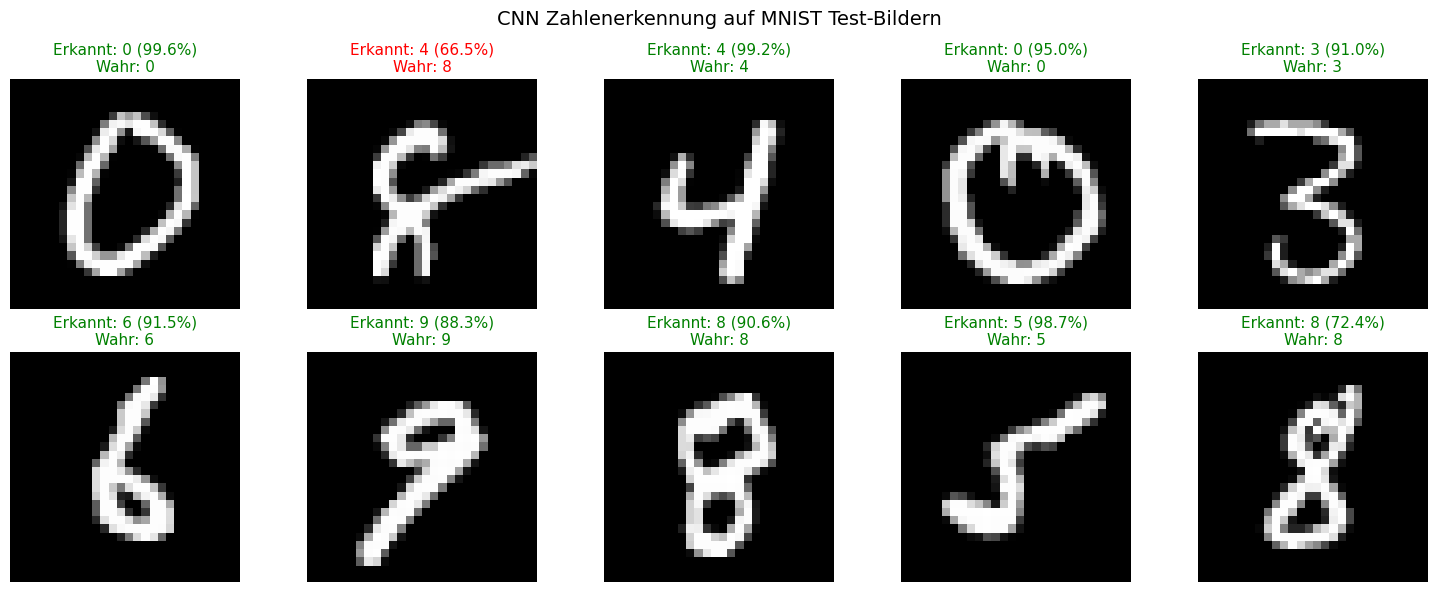

In [19]:
# DEMO: ERKENNUNG AUF MNIST TEST-BILDERN

# Hole einige zufällige Testbilder
test_images, test_labels = next(iter(train_loader_gan))

# Wähle 10 zufällige Bilder
indices = random.sample(range(len(test_images)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

cnn_model.eval()
with torch.no_grad():
    for idx, ax in enumerate(axes):
        img_idx = indices[idx]
        img = test_images[img_idx]
        true_label = test_labels[img_idx].item()

        # Vorhersage
        output = cnn_model(img.unsqueeze(0).to(device))
        prob = torch.softmax(output, dim=1)
        pred_label = output.argmax(1).item()
        confidence = prob[0][pred_label].item() * 100

        # Bild anzeigen
        ax.imshow(img.squeeze().numpy(), cmap='gray')

        # Farbe basierend auf Korrektheit
        color = 'green' if pred_label == true_label else 'red'
        ax.set_title(f"Erkannt: {pred_label} ({confidence:.1f}%)\nWahr: {true_label}",
                    color=color, fontsize=11)
        ax.axis('off')

plt.suptitle("CNN Zahlenerkennung auf MNIST Test-Bildern", fontsize=14)
plt.tight_layout()
plt.show()